# Regression Tree Using Python


Import required packages

In [1]:
%matplotlib inline
import warnings
from pathlib import Path

import pandas as pd
import numpy as np
import math
import dmba
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score
from dmba import plotDecisionTree, regressionSummary, classificationSummary


In [2]:
car_df = dmba.load_data('ToyotaCorolla.csv')
# Select the required columns
columns = ['Price', 'Age_08_04', 'KM', 'Fuel_Type', 'HP', 'Automatic', 
           'Doors', 'Quarterly_Tax', 'Mfr_Guarantee', 'Guarantee_Period', 
           'Airco', 'Automatic_airco', 'CD_Player', 'Powered_Windows', 
           'Sport_Model', 'Tow_Bar']

car_df = car_df[columns]

# Convert Fuel_Type to dummy variables
car_df = pd.get_dummies(car_df, drop_first=True)

# Make sure that the result is as expected
car_df.head()

Price  Age_08_04     KM  HP  Automatic  Doors  Quarterly_Tax  \
0  13500         23  46986  90          0      3            210   
1  13750         23  72937  90          0      3            210   
2  13950         24  41711  90          0      3            210   
3  14950         26  48000  90          0      3            210   
4  13750         30  38500  90          0      3            210   

   Mfr_Guarantee  Guarantee_Period  Airco  Automatic_airco  CD_Player  \
0              0                 3      0                0          0   
1              0                 3      1                0          1   
2              1                 3      0                0          0   
3              1                 3      0                0          0   
4              1                 3      1                0          0   

   Powered_Windows  Sport_Model  Tow_Bar  Fuel_Type_Diesel  Fuel_Type_Petrol  
0                1            0        0                 1                 0  
1                0            0        0                 1                 0  
2                0            0        0                 1                 0  
3                0            0        0                 1                 0  
4                1            0        0                 1                 0

Split dataset into training and validation set


In [3]:
X = car_df.drop(columns='Price')
y = car_df['Price']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (861, 16) Validation set: (575, 16)



Run a regression tree (RT) with the output variable Price and input variables Age_08_04, KM, Fuel_Type (= Petrol and Diesel), HP, Automatic,
Doors, Quarterly_Tax, Mfr_Guarantee, Guarantee_Period, Airco, Automatic_Airco, CD_Player, Powered_Windows, Sport_Model, and Tow_Bar.

Fit a deep regression tree and compare its prediction errors in the training and validation sets

In [4]:
# setting random state will ensure that the same tree is produced every time
deepTree = DecisionTreeRegressor(random_state=1)
deepTree.fit(train_X, train_y)

print('Tree has {} nodes'.format(deepTree.tree_.node_count))
plotDecisionTree(deepTree, feature_names=train_X.columns, impurity=False)

Tree has 1485 nodes
dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.951754 to fit



Which appear to be the three or four most important car specifications for predicting the car’s price? Use the <code>feature_importances_</code> property of the tree.

In [5]:
importance = pd.DataFrame({'features': train_X.columns, 
                           'importance': deepTree.feature_importances_})
importance.sort_values(by='importance', ascending=False)

features  importance
0          Age_08_04    0.844867
2                 HP    0.053789
1                 KM    0.049601
9    Automatic_airco    0.013358
5      Quarterly_Tax    0.006769
11   Powered_Windows    0.005221
4              Doors    0.004864
8              Airco    0.004727
12       Sport_Model    0.004459
6      Mfr_Guarantee    0.003714
7   Guarantee_Period    0.002385
13           Tow_Bar    0.002345
10         CD_Player    0.002088
3          Automatic    0.001334
15  Fuel_Type_Petrol    0.000470
14  Fuel_Type_Diesel    0.000011

Compare the prediction errors of the training, and validation, by examining their RMSE.

In [6]:
regressionSummary(train_y, deepTree.predict(train_X))
regressionSummary(valid_y, deepTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 0.0000
            Mean Absolute Error (MAE) : 0.0000
          Mean Percentage Error (MPE) : 0.0000
Mean Absolute Percentage Error (MAPE) : 0.0000

Regression statistics

                      Mean Error (ME) : 76.6557
       Root Mean Squared Error (RMSE) : 1492.3365
            Mean Absolute Error (MAE) : 1152.4852
          Mean Percentage Error (MPE) : -0.3363
Mean Absolute Percentage Error (MAPE) : 11.3783


## Grid search

Redo the tree, this time adjusting the parameters to yield a shallower tree. Compare the RMSE to the deeper tree.

Tree has 59 nodes


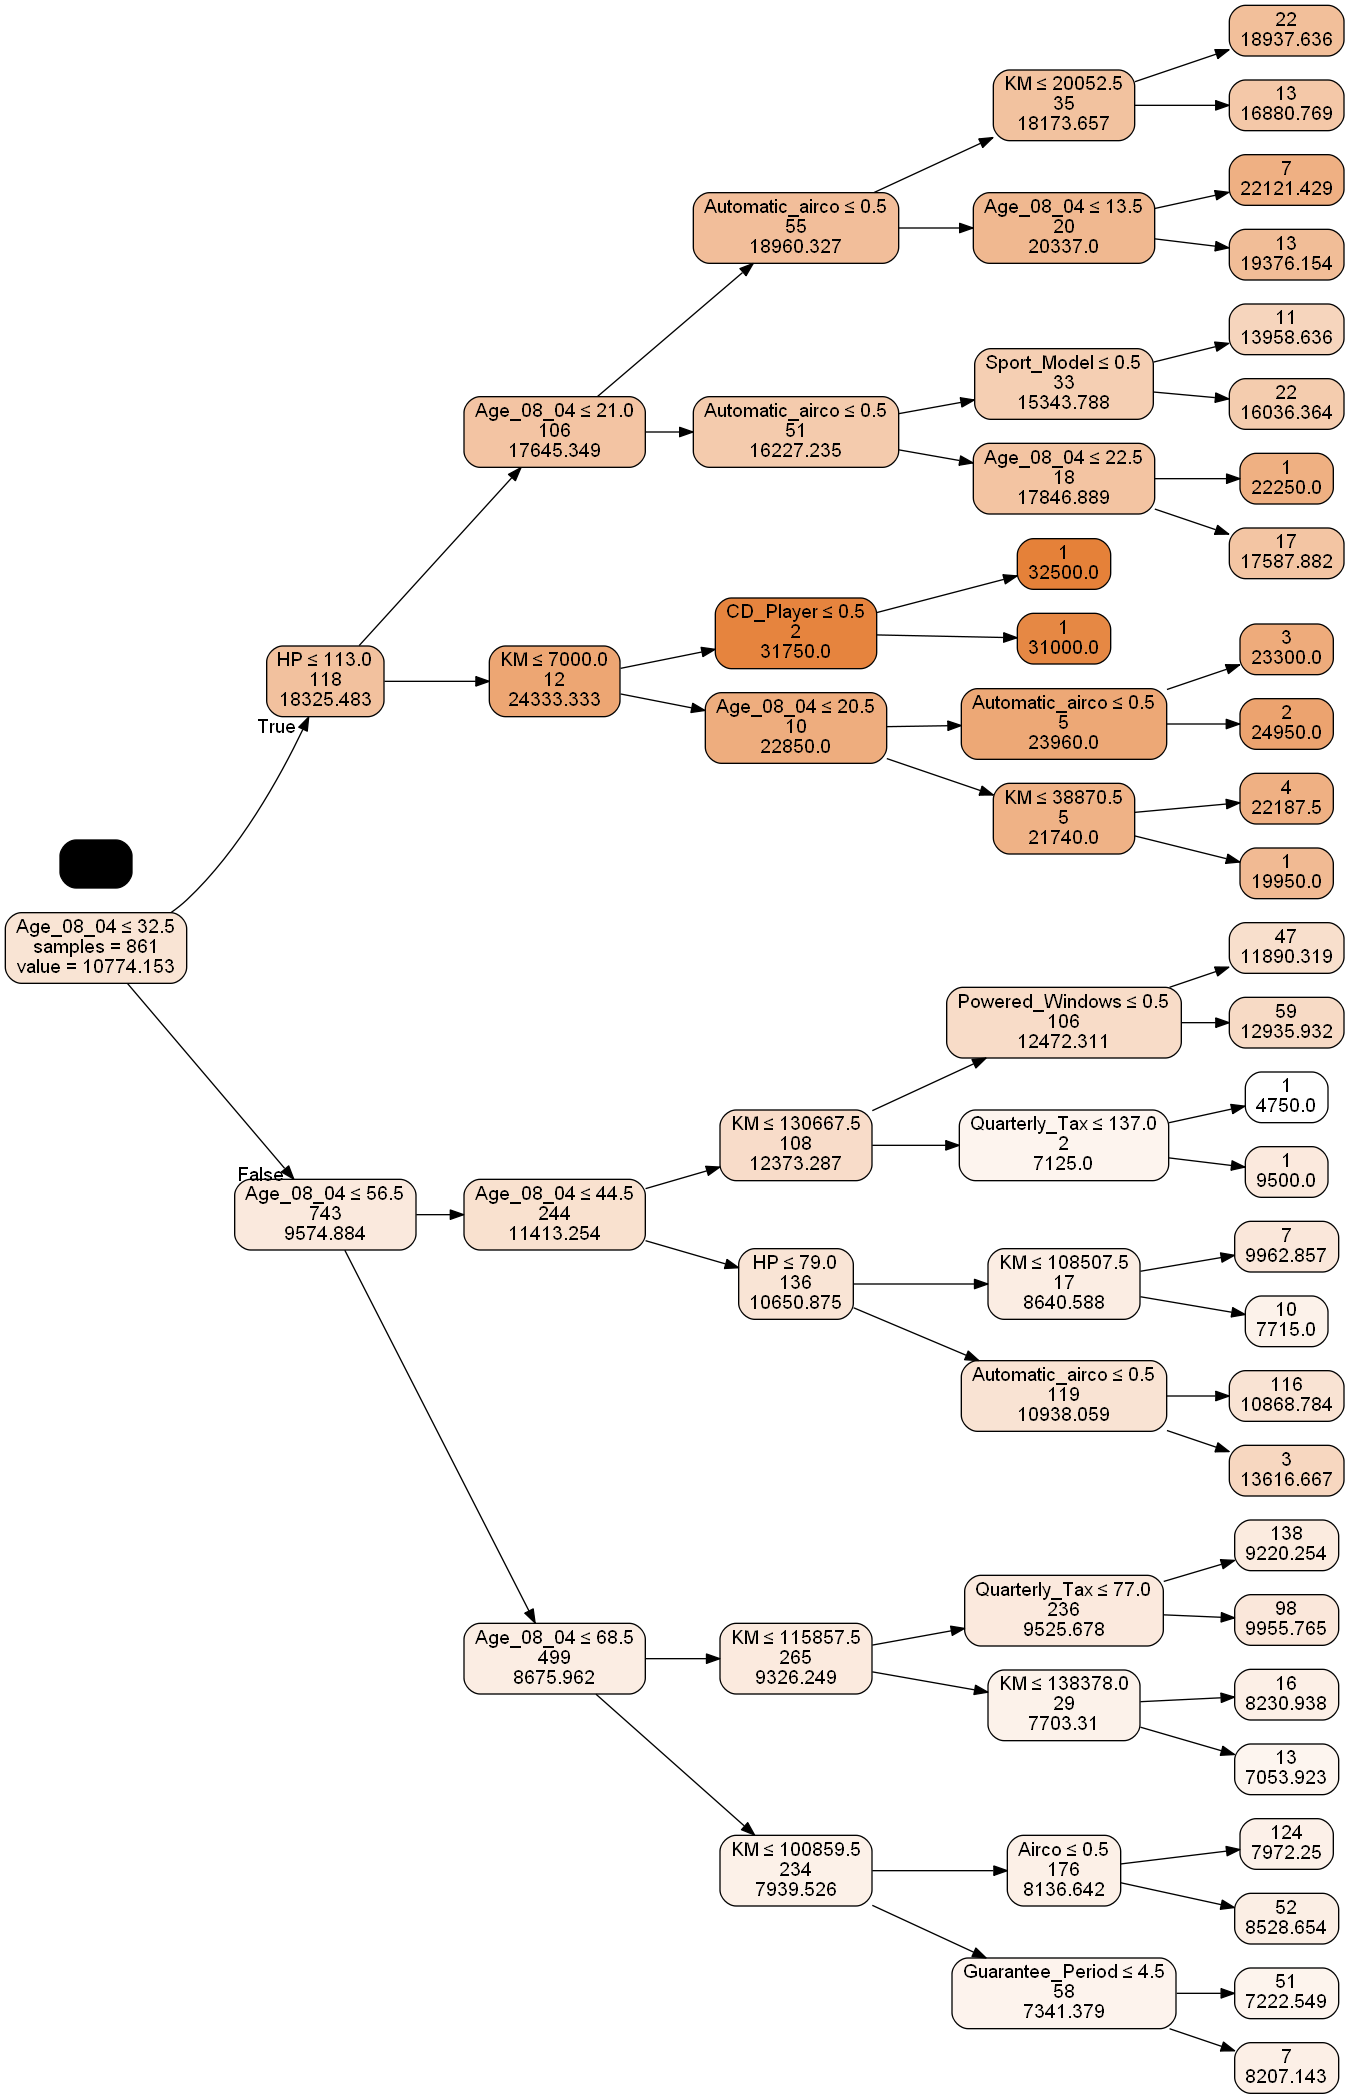

In [7]:
shallowTree = DecisionTreeRegressor(max_depth=5)
shallowTree.fit(train_X, train_y)
print('Tree has {} nodes'.format(shallowTree.tree_.node_count))
plotDecisionTree(shallowTree, feature_names=train_X.columns, rotate=True, impurity=False)

In [8]:
regressionSummary(train_y, shallowTree.predict(train_X))
regressionSummary(valid_y, shallowTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 1028.0279
            Mean Absolute Error (MAE) : 773.2770
          Mean Percentage Error (MPE) : -1.0039
Mean Absolute Percentage Error (MAPE) : 7.6715

Regression statistics

                      Mean Error (ME) : 53.4944
       Root Mean Squared Error (RMSE) : 1154.5669
            Mean Absolute Error (MAE) : 910.3207
          Mean Percentage Error (MPE) : -0.7987
Mean Absolute Percentage Error (MAPE) : 9.2168


For the shallower tree, the RMSE values of training and validation sets are comparable. Compared to the deep tree, the RMSE of the validation set is lower. 
This shallower tree does much worse on the training set than the deep tree but does better in predicting rows in the validation set. This indicates a more robust model.


Determine an optimal set of parameters (<code>max_depth</code>, <code>min_impurity_decrease</code>, <code>min_samples_split</code>) using cross-validated grid search.

Initial parameters:  {'max_depth': 10, 'min_impurity_decrease': 0, 'min_samples_split': 20}
Improved parameters:  {'max_depth': 6, 'min_impurity_decrease': 0, 'min_samples_split': 21}
Tree has 61 nodes


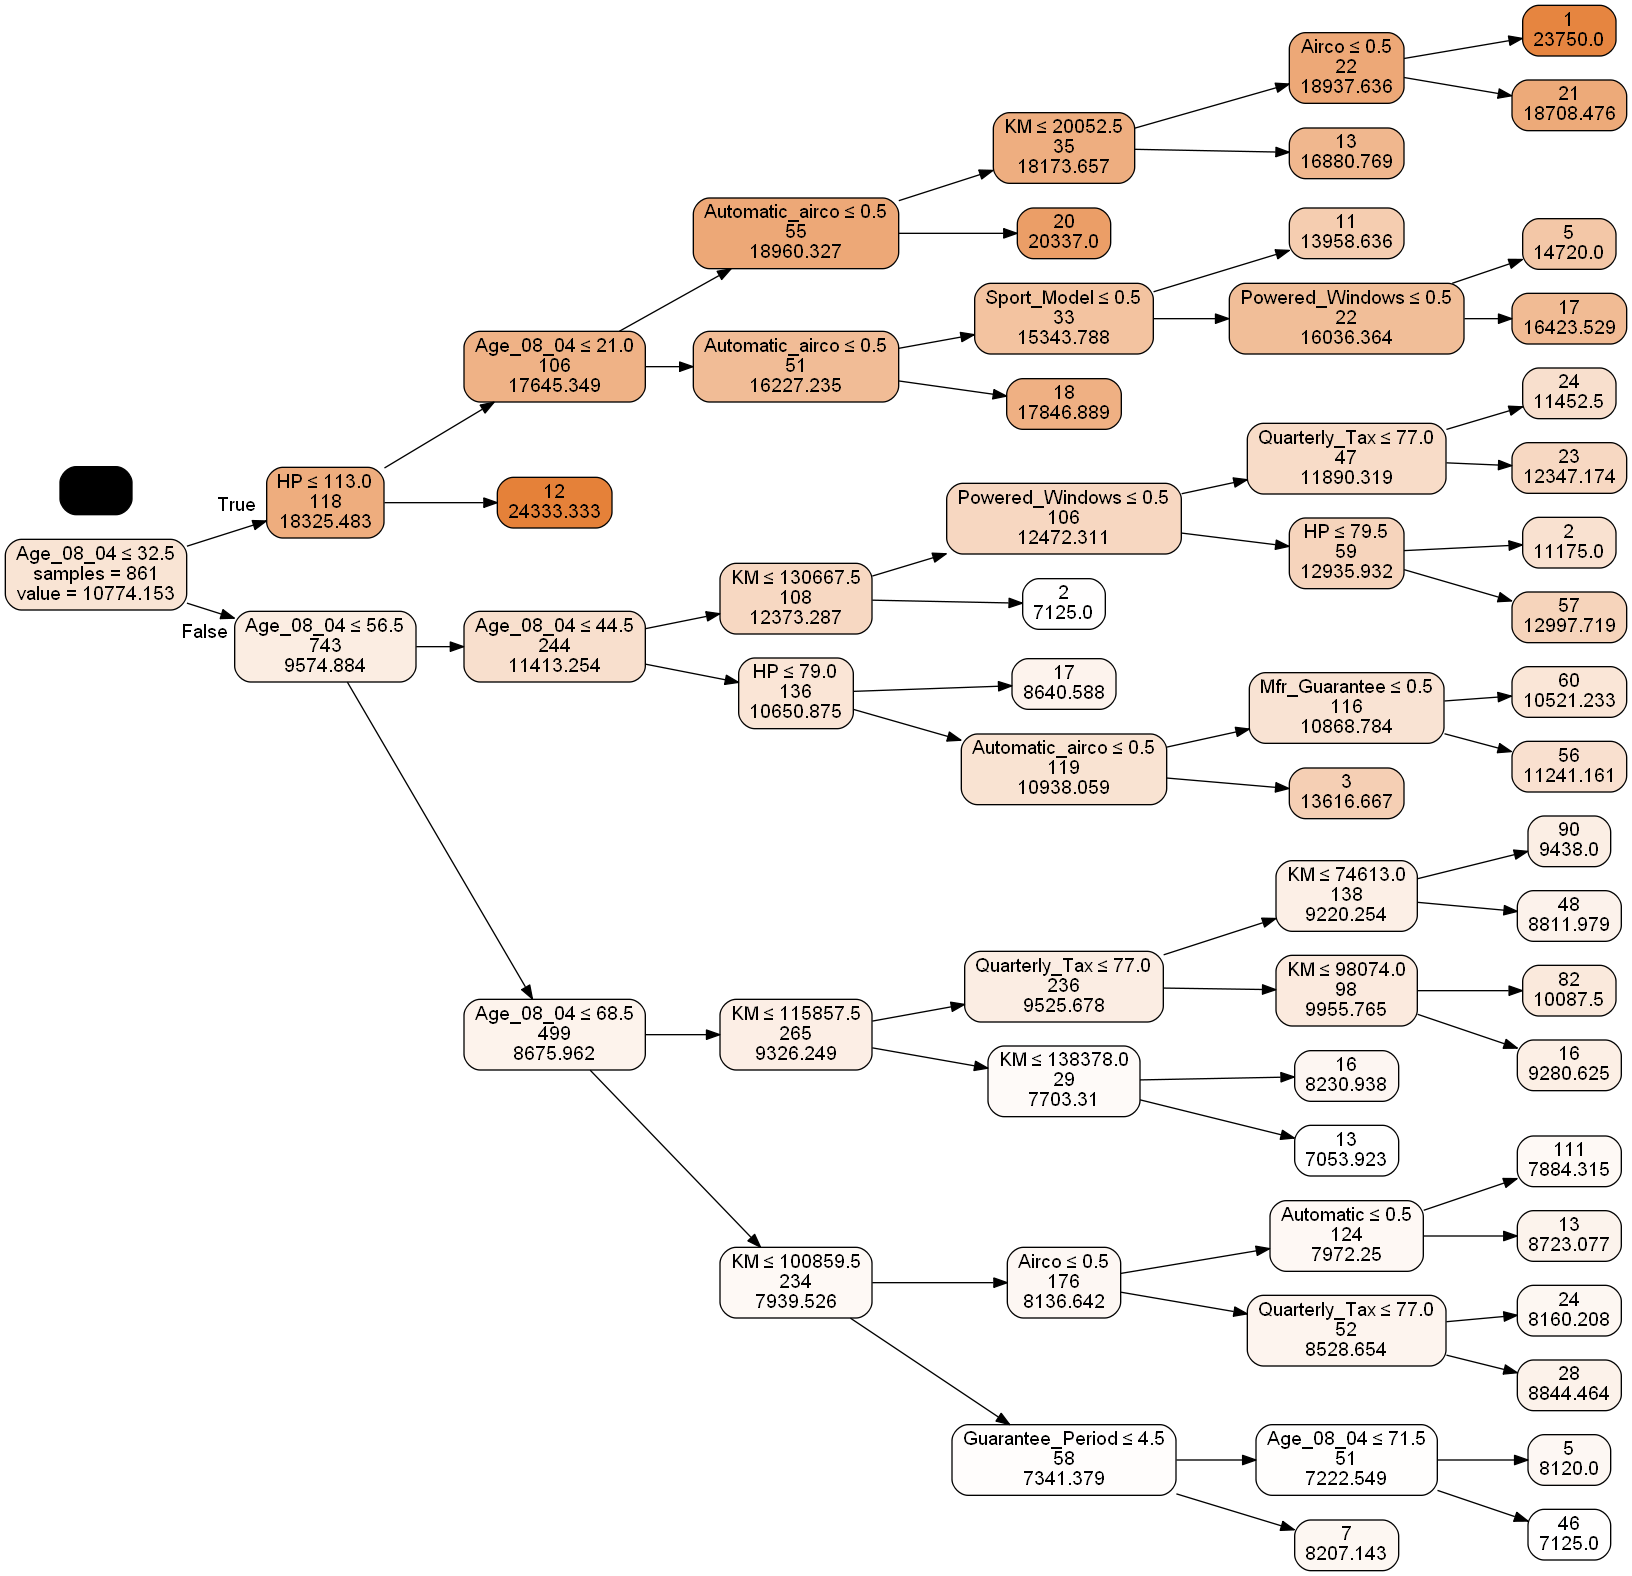

In [9]:
# user grid search to find optimized tree
param_grid = {
    'max_depth': [5, 10, 15, 20, 25], 
    'min_impurity_decrease': [0, 0.001, 0.005, 0.01], 
    'min_samples_split': [10, 20, 30, 40, 50], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Initial parameters: ', gridSearch.best_params_)

param_grid = {
    'max_depth': [5, 6, 7, 8, 9, 10, 11, 12, 13], 
    'min_impurity_decrease': [0, 0.001, 0.002, 0.003, 0.004, 0.005, 
                              0.006, 0.007], 
    'min_samples_split': [17, 18, 19, 20, 21, 22, 23], 
}
gridSearch = GridSearchCV(DecisionTreeRegressor(random_state=1), 
                          param_grid, cv=5, n_jobs=-1)
gridSearch.fit(train_X, train_y)
print('Improved parameters: ', gridSearch.best_params_)

optRegTree = gridSearch.best_estimator_

importanceRT = pd.DataFrame({'features': train_X.columns, 
                             'importance': deepTree.feature_importances_})

print('Tree has {} nodes'.format(optRegTree.tree_.node_count))
plotDecisionTree(optRegTree, feature_names=train_X.columns, rotate=True)

What is the performance of the optimized model on the training and validation sets?

In [10]:
regressionSummary(train_y, optRegTree.predict(train_X))
regressionSummary(valid_y, optRegTree.predict(valid_X))


Regression statistics

                      Mean Error (ME) : 0.0000
       Root Mean Squared Error (RMSE) : 1100.9381
            Mean Absolute Error (MAE) : 799.4101
          Mean Percentage Error (MPE) : -1.0081
Mean Absolute Percentage Error (MAPE) : 7.6852

Regression statistics

                      Mean Error (ME) : 23.7040
       Root Mean Squared Error (RMSE) : 1240.2015
            Mean Absolute Error (MAE) : 950.0088
          Mean Percentage Error (MPE) : -1.0616
Mean Absolute Percentage Error (MAPE) : 9.5168


Based on this analysis, we could pick a decision tree of maximum depth 6. For this tree depth, the training set RMSE is 842 and the validation set RMSE 1237.